In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import gensim
import warnings
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
nltk.download('punkt')
warnings.simplefilter("ignore", DeprecationWarning)

[nltk_data] Downloading package punkt to /home/serkan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
print(stop_word_list)

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani']


In [3]:
data = pd.read_excel('topic_modeling.xlsx')

In [4]:
data.head()

,Class,Document
0,astronomi,NGC 5713 Başak takımyıldızı bölgesinde bulunan...
1,astronomi,Birçok katalogda sarmal gökada olarak sınıflan...
2,hükümet,"Corina Casanova , İsviçre Federal Şansölyesidir ."
3,yasa,"Casanova , İsviçre Federal Yüksek Mahkemesi es..."
4,hükümet,Corina Casanova bir federal parlementerdir .


In [50]:
data.shape

(647809, 2)

In [5]:
class_ = Counter(data['Class']).keys()
class_

dict_keys(['astronomi', 'hükümet', 'yasa', 'bölge', 'televizyon', 'bilgisayar', 'işletme', 'film', 'tıp', 'askeri', 'zaman', 'organizasyon', 'spor', 'futbol', 'inşaat', 'coğrafya', 'müzik', 'oyunlar', 'insanlar', 'kraliyet hanedanı', 'eğitim', 'ödül', 'biyoloji', 'internet', 'simgeler', 'kitaplar', 'ortak_medya', 'görsel_sanat', 'travel', 'kurgusal_evren', 'havacılık', 'ulaşım', 'kimya', 'dil', 'finans', 'otomotiv', 'opera', 'çizgiromanlar', 'basketbol', 'yemek', 'interests', 'tiyatro', 'din', 'ölçü_birimi', 'moda', 'meteoroloji', 'mühendislik', 'exhibitions', 'fizik'])

In [6]:
sum_ = Counter(data['Class']).values()
sum_

dict_values([4997, 19921, 3083, 89926, 20612, 7366, 8258, 42623, 12107, 21378, 11146, 14847, 32363, 8560, 5023, 7340, 53235, 5685, 129943, 7683, 8423, 14214, 18917, 2357, 5160, 21726, 6155, 3984, 3552, 7883, 3982, 4156, 4696, 5352, 942, 2448, 4125, 1782, 3721, 4222, 1479, 2101, 6734, 1228, 460, 212, 1078, 129, 495])

In [7]:
df = pd.DataFrame(zip(class_,sum_), columns = ['Class', 'Toplam'])
df.head()

,Class,Toplam
0,astronomi,4997
1,hükümet,19921
2,yasa,3083
3,bölge,89926
4,televizyon,20612


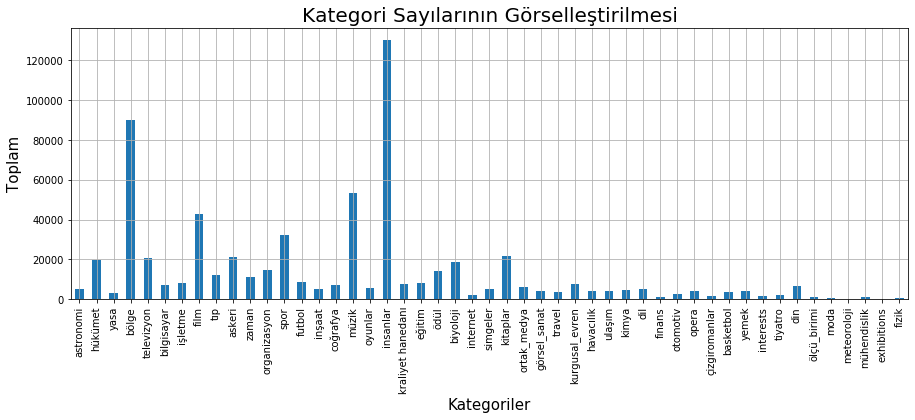

In [8]:
df.plot(x = 'Class' , y = 'Toplam',kind = 'bar', legend = False, grid = True, figsize = (15,5))
plt.title('Kategori Sayılarının Görselleştirilmesi', fontsize = 20)
plt.xlabel('Kategoriler', fontsize = 15)
plt.ylabel('Toplam', fontsize = 15);

In [9]:
docs = data['Document']

In [18]:
docs = docs.map(lambda x: re.sub('[,\.!?();:$%&#"]', '', x))
docs = docs.map(lambda x: x.lower())
docs = docs.map(lambda x: x.strip())

In [19]:
def token(values):
    filtered_words = [word for word in values.split() if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

docs = docs.map(lambda x: token(x))

In [20]:
data['Document'] = docs
data['Document'] = data['Document'].map(lambda x: x.strip())
print(data.head(20))

         Class                                           Document
0    astronomi  ngc 5713 başak takımyıldızı bölgesinde bulunan...
1    astronomi  birçok katalogda sarmal gökada olarak sınıflan...
2      hükümet     corina casanova i̇sviçre federal şansölyesidir
3         yasa  casanova i̇sviçre federal yüksek mahkemesi esk...
4      hükümet         corina casanova bir federal parlementerdir
5        bölge  casanova hristiyan demokrat halk partisi üyesi...
6      hükümet  i̇sviçre dışişleri bakanlığı i̇sviçre federal ...
7      hükümet  i̇sviçre'nin dış ilişkilerini sürdürmekle göre...
8        bölge  gilgit baltistan pakistan kuzey bölgeler urduc...
9        bölge  72496 km alan kaplamakta oldukça dağlık bir ar...
10       bölge                       bölgesel başkenti gilgit'dir
11       bölge  urduca peştuca wakhi shina balti khuar buruşas...
12       bölge  denton amerika birleşik devletleri'nde teksas ...
13       bölge  coğrafî olarak oklahoma teksas sınırının 61 ki...
14       b

In [21]:
dataDoc = data['Document'].values.tolist()
dataClass = data['Class'].values.tolist()

In [22]:
dataClass[301]

'spor'

In [23]:
dataDoc[301]

"aek takımından serbest bırakıldıktan sonra abd'nin major league futbol takımlarından seattle sounders fc deneme antrenmanlarına çıktı"

In [24]:
x_train, x_test, y_train, y_test = train_test_split(dataDoc, dataClass, test_size = 0.3, random_state = 42)

In [25]:
words_counts = Counter([word for line in x_train for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:20]

In [26]:
most_common_words[:20]

[('bir', 121182),
 ('olarak', 48115),
 ('olan', 39859),
 ('yılında', 30484),
 ('tarafından', 24377),
 ('sonra', 23792),
 ('ilk', 23313),
 ('büyük', 16955),
 ('yer', 15010),
 ('arasında', 12783),
 ('oldu', 12070),
 ('kadar', 11815),
 ('the', 11342),
 ('2', 10580),
 ('iki', 10370),
 ('bulunan', 9993),
 ('aynı', 9876),
 ('1', 9866),
 ('dünya', 9489),
 ('adlı', 9265)]

In [27]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)

In [28]:
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# OneVsRest LogisticRegression modeli

In [29]:
model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C=1.0))
model.fit(x_train_tfidf, y_train)

/home/serkan/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
model.predict(x_test_tfidf).tolist()

In [ ]:
model.decision_function(x_test_tfidf)

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def evaluation_scores(y_val, predicted):
    
    print ("Accracy={}".format(accuracy_score(y_val, predicted)))
    print ("F1_macro={}".format(f1_score(y_val, predicted, average='macro')))
    print ("F1_micro={}".format(f1_score(y_val, predicted, average='micro')))
    print ("F1_wted={}".format(f1_score(y_val, predicted, average='weighted')))
    return accuracy_score(y_val, predicted)
    
logisticpred = evaluation_scores(y_test, model.predict(x_test_tfidf))

Accracy=0.6042203732575909
F1_macro=0.4466958289586697
F1_micro=0.6042203732575909
F1_wted=0.5842868528795913


# OvR Stochastic Gradient Descent

In [35]:
model2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge', penalty = 'elasticnet', max_iter = 5))
model2.fit(x_train_tfidf, y_train)

/home/serkan/.local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=5,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='elasticnet', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [36]:
model2.predict(x_test_tfidf)

array(['insanlar', 'bölge', 'insanlar', ..., 'insanlar', 'travel', 'spor'],
      dtype='<U17')

In [37]:
sgdpred = evaluation_scores(y_test, model2.predict(x_test_tfidf))

Accracy=0.46510036378979436
F1_macro=0.28398738685096797
F1_micro=0.46510036378979436
F1_wted=0.44763389961052275


# OvR LineerSVC

In [32]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [33]:
SVC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
SVC_pipeline.fit(x_train_tfidf, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight=None,
                                                         dual=True,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         loss='squared_hinge',
                                                         max_iter=1000,
                                                         multi_class='ovr',
                                                         penalty='l2',
                                                         random_state=None,
                                                         tol=0.0001,
                                                         verbose=0),
                                     n_jobs=1))],
         verbose=False)

In [34]:
prediction = SVC_pipeline.predict(x_test_tfidf)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
lineersvcpred = accuracy_score(y_test, prediction)

Test accuracy is 0.645472180629094


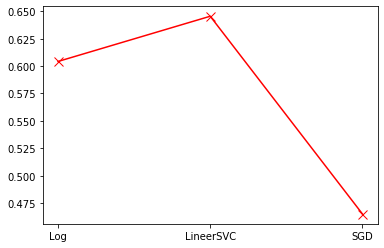

In [49]:
accuracys = [logisticpred,lineersvcpred,sgdpred]
plt.plot(["Log", "LineerSVC", "SGD"],accuracys , marker = "x" , markersize = 9 , color = "red");

# LDA modeli

In [38]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
tf = tf_vectorizer.fit_transform(dataDoc)

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
lda = LDA(n_components=30, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lda,tf_feature_names,30)